# (PDF) VLM Image Description Test
* Docling의 ImageDescription 기능 테스트
* VLM으로 ImageNode / TableNode의 이미지에 대한 설명, OCR 추출 -> 텍스트 정보로 활용

In [1]:
import os
from pydantic import BaseModel
import sys
# for debugging
parent_dir = os.path.dirname(os.path.dirname(os.getcwd()))
print(parent_dir)
core_src_dir = os.path.join(parent_dir, "src/psiking-core")
print(core_src_dir)
sys.path.append(core_src_dir)


from config import settings
os.environ["DOCLING_ARTIFACTS_PATH"] = settings.docling_artifacts_path

/Users/id4thomas/github/psi-king
/Users/id4thomas/github/psi-king/src/psiking-core


# 1. Initialize DoclingPDFReader

## 1-1. Initialize Docling Converter

In [2]:
from docling_core.types.doc import PictureItem

from docling.datamodel.base_models import InputFormat

from docling.datamodel.pipeline_options import (
    AcceleratorDevice,
    VlmPipelineOptions,
    PdfPipelineOptions,
    PictureDescriptionApiOptions,
    ResponseFormat,
    TableStructureOptions,
    TableFormerMode
)
from docling.document_converter import DocumentConverter, PdfFormatOption
from docling.pipeline.vlm_pipeline import VlmPipeline
from docling.datamodel.pipeline_options_vlm_model import (
    ApiVlmOptions,
    InferenceFramework,
    InlineVlmOptions,
    ResponseFormat,
    TransformersModelType
)

In [3]:
pipeline_options = PdfPipelineOptions()

# If force_backend_text = True, text from backend will be used instead of generated text
pipeline_options.force_backend_text = False
pipeline_options.generate_picture_images = True

pipeline_options.images_scale = 1.5
pipeline_options.generate_page_images = True
pipeline_options.generate_picture_images = True
pipeline_options.do_ocr = False

# TableStructure
pipeline_options.do_table_structure = True
pipeline_options.table_structure_options = TableStructureOptions(mode=TableFormerMode.ACCURATE)

pipeline_options.accelerator_options.device = AcceleratorDevice.MPS

In [4]:
# Picture Annotation (picture_description_options) using VLM
# https://docling-project.github.io/docling/examples/pictures_description_api/

# "Describe the image in three sentences. Be consise and accurate.",
DESCRIPTION_INSTRUCTION = '''주어진 이미지에 대해 2가지 정보를 반환합니다.
* description: 최대 2문장 정도로 이미지에 대한 간결한 설명
* text: 이미지 내에서 인식된 모든 텍스트
Description은 한국어로 작성, text는 인식된 언어 그대로 작성합니다.
다음 JSON 형식으로 반환하세요 {"description": str, "text": str}'''

class ImageDescription(BaseModel):
    description: str
    text: str
    
    class Config:
        extra='forbid'

def vllm_local_picture_description_options(
    base_url: str,
    api_key: str,
    model: str
):
    options = PictureDescriptionApiOptions(
        url=f"{base_url}/v1/chat/completions",
        headers = {
            'Authorization': f'Bearer {api_key}'
        },
        params=dict(
            model=model,
            seed=42,
            max_completion_tokens=8192,
            temperature=0.9,
            extra_body={"guided_json": ImageDescription.model_json_schema()}
        ),
        prompt=DESCRIPTION_INSTRUCTION,
        timeout=180,
    )
    return options

def openai_picture_description_options(
    base_url: str,
    api_key: str,
    model: str
):
    options = PictureDescriptionApiOptions(
        url=f"{base_url}/v1/chat/completions",
        headers = {
            'Authorization': f'Bearer {api_key}'
        },
        params=dict(
            model=model,
            seed=42,
            max_completion_tokens=8192,
            # temperature=0.9,
            response_format={
                "type": "json_schema",
                "json_schema": {
                    "name": "picture_description",
                    "strict": True,
                    "schema": ImageDescription.model_json_schema()
                }
            }
        ),
        prompt=DESCRIPTION_INSTRUCTION,
        timeout=180,
        # percentage of the area for a picture to processed with the models
        picture_area_threshold=0.02
    )
    return options

pipeline_options.do_picture_description = True
pipeline_options.enable_remote_services = True

print(settings.vlm_model)
pipeline_options.picture_description_options=openai_picture_description_options(
    base_url=settings.vlm_base_url,
    api_key=settings.vlm_api_key,
    model=settings.vlm_model
)

gpt-4.1-mini


In [5]:
converter = DocumentConverter(
    allowed_formats = [
        InputFormat.PDF,
    ],
    format_options={
        InputFormat.PDF: PdfFormatOption(
            pipeline_options=pipeline_options,
        ),
    }
)

## 1-2. Initialize PSIKing Reader

In [6]:
from psiking.core.reader.pdf.docling_reader import DoclingPDFReader

# initalize reader
reader = DoclingPDFReader(converter=converter)

# 2. Test

## 2-1. Image Figures

In [7]:
fname = 'samples/allganize_finance_figure_sample1.pdf'

In [8]:
document = reader.run(fname, extra_info = {})

In [9]:
len(document.nodes)
node_types = [type(x) for x in document.nodes]
# node_types

(309, 175)
TEXT: 'Fed 기준금리(%)\tS&P 500(pt)\t美 10년물(%)\n인하 前\t인하 後\t前\t後\t前\t後\n1995년\t6.0\t5.25\t545\t636\t6.2\t5.6\n1998년\t5.5\t4.75\t957\t1,164\t4.9\t4.7'
CAPTION: '이 이미지는 1995년과 1998년의 Fed 기준금리, S&P 500 지수, 미국 10년물 금리를 년도별로 나열한 표입니다. 각 항목별 인하 전후 금리 및 지수 변동이 표시되어 있습니다.'


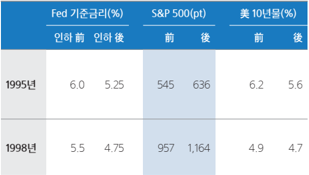

In [10]:
## Small Image
image_node = document.nodes[5]
# image_node = document.nodes[15]
# image_node = document.nodes[21]
print(image_node.image.size)
print("TEXT:", repr(image_node.text))
print("CAPTION:",repr(image_node.caption))
image_node.image

(302, 188)
TEXT: '(bps) (%) 3개월-10년 스프레드 (좌측) Fed 기준금리 (우측) 1990 1993 1996 1999 450 400 350 300 250 200 150 100 50 0 9 8 7 6 5 4 3 2'
CAPTION: '1990년부터 2000년까지의 Fed 기준금리와 3개월에서 10년 스프레드 변화를 나타내는 그래프입니다. 파란색 선은 Fed 기준금리(우측 축), 회색 선은 3개월-10년 스프레드(좌측 축)를 나타냅니다.'


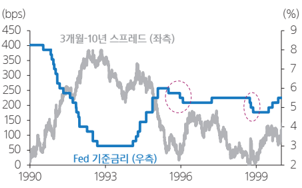

In [14]:
# image_node = document.nodes[5]
image_node = document.nodes[15]
# image_node = document.nodes[21]
print(image_node.image.size)
print("TEXT:", repr(image_node.text))
print("CAPTION:",repr(image_node.caption))
image_node.image

## 2-2. Tables

In [23]:
from IPython.display import HTML

In [15]:
fname = 'samples/allganize_finance_table_sample1.pdf'

In [16]:
document = reader.run(fname, extra_info = {})

In [17]:
len(document.nodes)
node_types = [type(x) for x in document.nodes]
node_types

[psiking.core.base.schema.TextNode,
 psiking.core.base.schema.TextNode,
 psiking.core.base.schema.TableNode,
 psiking.core.base.schema.TextNode,
 psiking.core.base.schema.TableNode,
 psiking.core.base.schema.TextNode,
 psiking.core.base.schema.TextNode]

(679, 281)
TEXT: '<table><tbody><tr><th>구분</th><th colspan="2">시 간</th><th>내 용</th></tr><tr><td rowspan="2">1부</td><td>14:30~14:40</td><td>10&#x27;</td><td>• 인사말 (권용원 금융투자협회 회장)</td></tr><tr><td>14:40~15:40</td><td>60&#x27;</td><td>• 리서치센터장 (4인) 의 하반기 전망</td></tr><tr><td>glyph&lt;c=14,font=/AAAAAH+*&gt;</td><td>15:40~15:45</td><td>5&#x27;</td><td>• Break</td></tr><tr><td>2부</td><td>15:45~16:35</td><td>50&#x27;</td><td>• 종합토론 (센터장 4인, 운용사 2인, 연구원 1인)</td></tr></tbody></table>'
CAPTION: ''


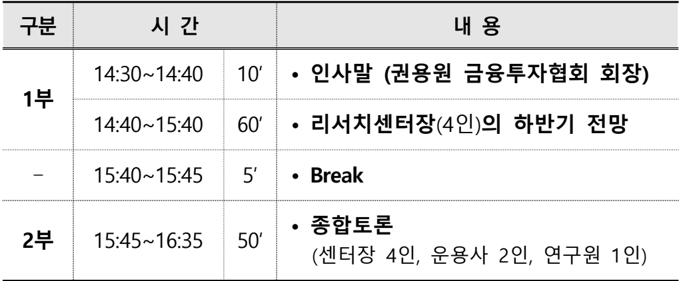

In [24]:
# Table 1
table_node = document.nodes[2]
print(table_node.image.size)
print("TEXT:", repr(table_node.text))
print("CAPTION:",repr(table_node.caption))
table_node.image

In [25]:
html_table = HTML(table_node.text)
html_table

(690, 302)
TEXT: '<table><tbody><tr><th>소속</th><th>성</th><th>소속</th><th>성 명</th></tr><tr><td>삼성증권</td><td>오현석 리서치센터장</td><td>미래에셋 자산운용</td><td>이준용 사장 (글로벌운용총괄)</td></tr><tr><td>하나금융투자</td><td>조용준 리서치센터장</td><td>한국투자 밸류자산운용</td><td>이채원 대표</td></tr><tr><td>SK증권</td><td>최석원 리서치센터장</td><td>자본시장 연구원</td><td>강현주 실장 (거시금융실)</td></tr><tr><td>NH투자증권</td><td>이창목 리서치센터장</td><td></td><td></td></tr></tbody></table>'
CAPTION: ''


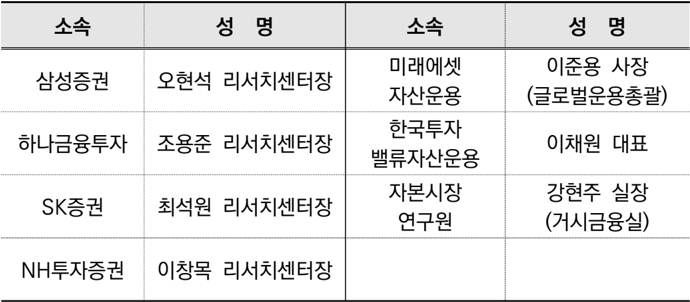

In [20]:
# Table 2
table_node = document.nodes[4]
print(table_node.image.size)
print("TEXT:", repr(table_node.text))
print("CAPTION:",repr(table_node.caption))
table_node.image

In [ ]:
html_table = HTML(table_node.text)
html_table

소속,성,소속,성 명
삼성증권,오현석 리서치센터장,미래에셋 자산운용,이준용 사장 (글로벌운용총괄)
하나금융투자,조용준 리서치센터장,한국투자 밸류자산운용,이채원 대표
SK증권,최석원 리서치센터장,자본시장 연구원,강현주 실장 (거시금융실)
NH투자증권,이창목 리서치센터장,,
